**Time Series Analysis**
1. Hitting Ability
2. Runs Scoring Ability
3. Pressure soaking Ability
4. Strike Rotation
**Time Series Forecasting**

**Problem Statement:**
**Auction**: Players who can fulfil the role of pinch hitter in powerplay for SRH?
**Pinch Hitter** = High SR, High balls_per_boundary, Decent Runs, Decent Balls Faced
Powerplay = 1-6 overs
SRH = Analysis By Team

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

In [3]:
deliveries=pd.read_csv('deliveries.csv')
matches=pd.read_csv('matches.csv')

In [4]:
deliveries.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,2,0,0,0,0,0,2,2,NaN,NaN,NaN


In [5]:
matches.head()

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,2017,Rajkot,2017-04-07,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,2017,Indore,2017-04-08,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,2017,Bangalore,2017-04-08,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN


In [8]:
def balls_per_dismissal(balls,dismissals):
  if dismissals > 0:
    return balls/dismissals
  else:
    return balls/1
def balls_per_boundary(balls,boundaries):
  if boundaries > 0:
    return balls/boundaries
  else:
    return balls/1
def playerStatistics(df):
  df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
  df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
  df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
  df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
  df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
  df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)

  runs = pd.DataFrame(df.groupby(['batsman', 'match_id'])['batsman_runs'].sum().reset_index()).groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'runs'})
  innings = pd.DataFrame(df.groupby(['batsman'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'match_id':'innings'})
  balls = pd.DataFrame(df.groupby(['batsman'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
  dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})

  dots = pd.DataFrame(df.groupby(['batsman'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
  ones = pd.DataFrame(df.groupby(['batsman'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
  twos = pd.DataFrame(df.groupby(['batsman'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
  threes = pd.DataFrame(df.groupby(['batsman'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
  fours = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
  sixes = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})

  df = pd.merge(innings, runs, on = 'batsman').merge(balls, on = 'batsman').merge(dismissals, on = 'batsman').merge(dots, on = 'batsman').merge(ones, on = 'batsman').merge(twos, on = 'batsman').merge(threes, on = 'batsman').merge(fours, on = 'batsman').merge(sixes, on = 'batsman')
  df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)
  df['RPI'] = df.apply(lambda x: x['runs']/x['innings'], axis = 1)
  df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)
  df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)
  return df

In [9]:
df=playerStatistics(deliveries)

In [10]:
df.head()

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,23,280,196,15,61,83,20,1,16,15,142.857143,12.173913,13.066667,6.322581
1,A Chandila,2,4,7,1,3,4,0,0,0,0,57.142857,2.000000,7.000000,7.000000
2,A Chopra,6,53,75,5,45,21,2,0,7,0,70.666667,8.833333,15.000000,10.714286
3,A Choudhary,3,25,20,2,4,13,1,0,1,1,125.000000,8.333333,10.000000,10.000000
4,A Dananjaya,1,4,5,0,2,2,1,0,0,0,80.000000,4.000000,5.000000,5.000000


In [11]:
def phase(over):
  if over <= 6:
    return 'Powerplay'
  elif over <= 15:
    return 'Middle'
  else:
    return 'Death'

In [12]:
deliveries['phase']=deliveries['over'].apply(lambda x: phase(x))

In [13]:
def phasesOfplay(df, current_phase):
  df = df[df.phase == current_phase]
  df.reset_index(inplace = True, drop = True)

  df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
  df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
  df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
  df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
  df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
  df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)

  runs = pd.DataFrame(df.groupby(['batsman', 'match_id'])['batsman_runs'].sum().reset_index()).groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'runs'})
  innings = pd.DataFrame(df.groupby(['batsman'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'match_id':'innings'})
  balls = pd.DataFrame(df.groupby(['batsman'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
  dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})

  dots = pd.DataFrame(df.groupby(['batsman'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
  ones = pd.DataFrame(df.groupby(['batsman'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
  twos = pd.DataFrame(df.groupby(['batsman'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
  threes = pd.DataFrame(df.groupby(['batsman'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
  fours = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
  sixes = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})

  df = pd.merge(innings, runs, on = 'batsman').merge(balls, on = 'batsman').merge(dismissals, on = 'batsman').merge(dots, on = 'batsman').merge(ones, on = 'batsman').merge(twos, on = 'batsman').merge(threes, on = 'batsman').merge(fours, on = 'batsman').merge(sixes, on = 'batsman')
  df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)
  df['RPI'] = df.apply(lambda x: x['runs']/x['innings'], axis = 1)
  df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)
  df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)
  return df

In [14]:
pp_df= phasesOfplay(deliveries, 'Powerplay')
mid_df= phasesOfplay(deliveries, 'Middle')
dth_df= phasesOfplay(deliveries, 'Death')

In [15]:
pp_df.head()

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,1,5,7,1,5,1,0,0,1,0,71.428571,5.000000,7.000000,7.000000
1,A Chopra,5,27,41,2,26,11,0,0,4,0,65.853659,5.400000,20.500000,10.250000
2,A Flintoff,1,14,15,0,11,1,0,1,1,1,93.333333,14.000000,15.000000,7.500000
3,A Hales,6,118,82,3,34,24,7,0,11,6,143.902439,19.666667,27.333333,4.823529
4,A Mishra,1,1,5,0,4,1,0,0,0,0,20.000000,1.000000,5.000000,5.000000


In [16]:
mid_df.head()

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,5,61,41,0,16,13,5,0,2,5,148.780488,12.200000,41.000000,5.857143
1,A Chopra,3,25,32,2,18,9,2,0,3,0,78.125000,8.333333,16.000000,10.666667
2,A Flintoff,2,23,24,1,8,13,1,0,2,0,95.833333,11.500000,24.000000,12.000000
3,A Hales,3,34,37,3,12,20,3,0,2,0,91.891892,11.333333,12.333333,18.500000
4,A Kumble,1,1,5,0,4,1,0,0,0,0,20.000000,1.000000,5.000000,5.000000


In [17]:
dth_df.head()

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,22,214,148,14,40,69,15,1,13,10,144.594595,9.727273,10.571429,6.434783
1,A Chandila,2,4,7,1,3,4,0,0,0,0,57.142857,2.000000,7.000000,7.000000
2,A Chopra,1,1,2,1,1,1,0,0,0,0,50.000000,1.000000,2.000000,2.000000
3,A Choudhary,3,25,20,2,4,13,1,0,1,1,125.000000,8.333333,10.000000,10.000000
4,A Dananjaya,1,4,5,0,2,2,1,0,0,0,80.000000,4.000000,5.000000,5.000000


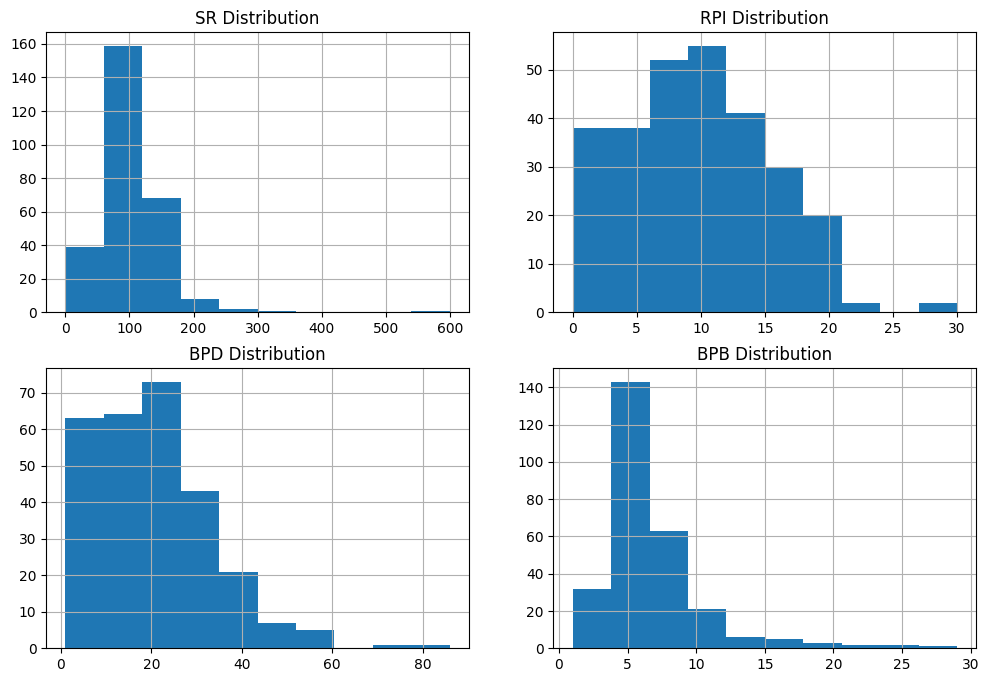

In [18]:
plt.figure(figsize=(12,8))

plt.subplot(221)
pp_df.SR.hist()
plt.title('SR Distribution')

plt.subplot(222)
pp_df.RPI.hist()
plt.title('RPI Distribution')

plt.subplot(223)
pp_df.BPD.hist()
plt.title('BPD Distribution')

plt.subplot(224)
pp_df.BPB.hist()
plt.title('BPB Distribution')

plt.show()

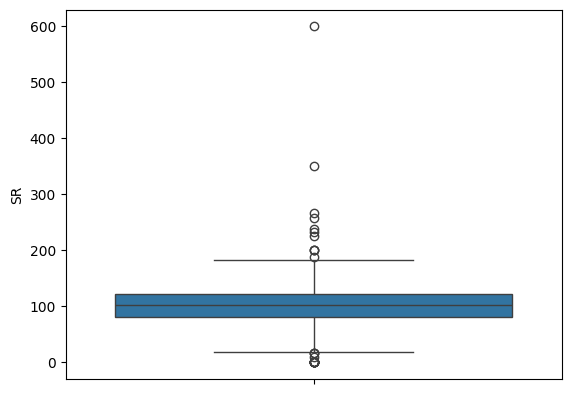

In [19]:
import seaborn as sns

sns.boxplot(pp_df['SR'])
plt.show()

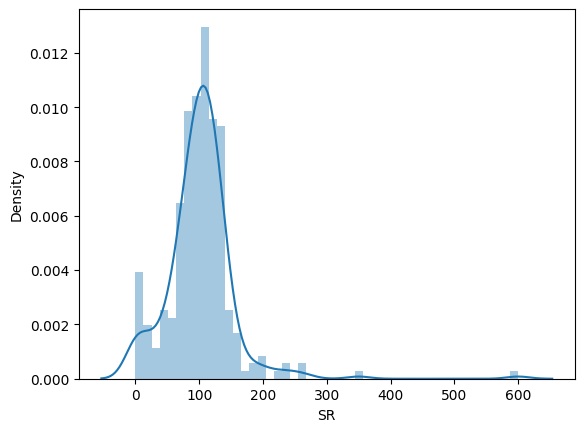

In [20]:
sns.distplot(pp_df['SR'])
plt.show()

In [21]:
np.percentile(pp_df['SR'],25)

80.38012982726373

In [22]:
np.percentile(pp_df['SR'],25),np.percentile(pp_df['SR'],50),np.percentile(pp_df['SR'],75)

(80.38012982726373, 103.18840579710145, 122.40779149784552)

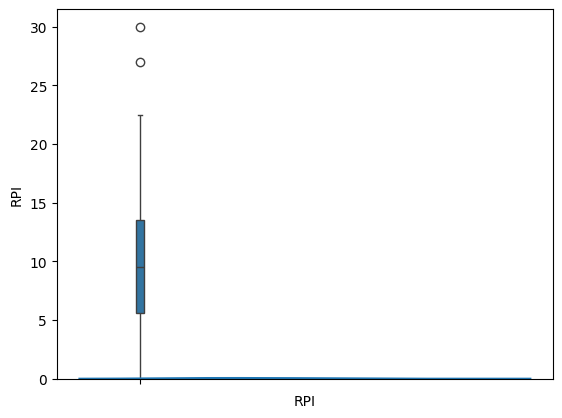

In [23]:
sns.boxplot(pp_df['RPI'])
plt.show()

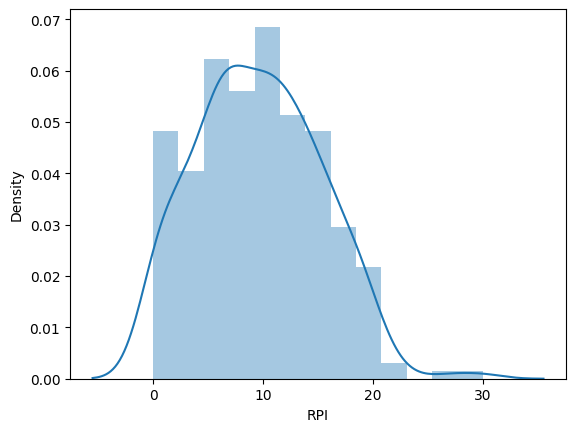

In [24]:
sns.distplot(pp_df['RPI'])
plt.show()

In [25]:
np.percentile(pp_df['RPI'],25),np.percentile(pp_df['RPI'],50),np.percentile(pp_df['RPI'],75)

(5.635416666666667, 9.5, 13.533288043478262)

In [30]:
wt_sr,wt_rpi,wt_bpd,wt_bpb=0.38, 0.25, 0.12,0.26

In [31]:
pp_df=pp_df[pp_df.innings >= 20]    #for 5 innings
pp_df.reset_index(inplace=True, drop=True)

In [32]:
pp_df['calc_SR'] = pp_df['SR'].apply(lambda x: x*x)
pp_df['calc_RPI'] = pp_df['RPI'].apply(lambda x: x*x)
pp_df['calc_BPD'] = pp_df['BPD'].apply(lambda x: x*x)
pp_df['calc_BPB'] = pp_df['BPB'].apply(lambda x: x*x)

sq_sr, sq_rpi, sq_bpd, sq_bpb = np.sqrt(pp_df[['calc_SR','calc_RPI', 'calc_BPD', 'calc_BPB']].sum(axis = 0))

pp_df['calc_SR'] = pp_df['calc_SR'].apply(lambda x: x/sq_sr)
pp_df['calc_RPI'] = pp_df['calc_RPI'].apply(lambda x: x/sq_rpi)
pp_df['calc_BPD'] = pp_df['calc_BPD'].apply(lambda x: x/sq_bpd)
pp_df['calc_BPB'] = pp_df['calc_BPB'].apply(lambda x: x/sq_bpb)

pp_df['calc_SR'] = pp_df['calc_SR'].apply(lambda x: x*wt_sr)
pp_df['calc_RPI'] = pp_df['calc_RPI'].apply(lambda x: x*wt_rpi)
pp_df['calc_BPD'] = pp_df['calc_BPD'].apply(lambda x: x*wt_bpd)
pp_df['calc_BPB'] = pp_df['calc_BPB'].apply(lambda x: x*wt_bpb)

best_sr, worst_sr = max(pp_df['calc_SR']), min(pp_df['calc_SR'])
best_rpi, worst_rpi = max(pp_df['calc_RPI']), min(pp_df['calc_RPI'])
best_bpd, worst_bpd = max(pp_df['calc_BPD']), min(pp_df['calc_BPD'])
best_bpb, worst_bpb = min(pp_df['calc_BPB']), max(pp_df['calc_BPB'])

In [33]:
pp_df['dev_best_SR'] = pp_df['calc_SR'].apply(lambda x: (x-best_sr)*(x-best_sr))
pp_df['dev_best_RPI'] = pp_df['calc_RPI'].apply(lambda x: (x-best_rpi)*(x-best_rpi))
pp_df['dev_best_BPD'] = pp_df['calc_BPD'].apply(lambda x: (x-best_bpd)*(x-best_bpd))
pp_df['dev_best_BPB'] = pp_df['calc_BPB'].apply(lambda x: (x-best_bpb)*(x-best_bpb))

pp_df['dev_best_sqrt'] = pp_df.apply(lambda x: x['dev_best_SR'] + x['dev_best_RPI'] + x['dev_best_BPD'] + x['dev_best_BPB'], axis = 1)

pp_df['dev_worst_SR'] = pp_df['calc_SR'].apply(lambda x: (x-worst_sr)*(x-worst_sr))
pp_df['dev_worst_RPI'] = pp_df['calc_RPI'].apply(lambda x: (x-worst_rpi)*(x-worst_rpi))
pp_df['dev_worst_BPD'] = pp_df['calc_BPD'].apply(lambda x: (x-worst_bpd)*(x-worst_bpd))
pp_df['dev_worst_BPB'] = pp_df['calc_BPB'].apply(lambda x: (x-worst_bpb)*(x-worst_bpb))

pp_df['dev_worst_sqrt'] = pp_df.apply(lambda x: x['dev_worst_SR'] + x['dev_worst_RPI'] + x['dev_worst_BPD'] + x['dev_worst_BPB'], axis = 1)

In [34]:
pp_df['score'] = pp_df.apply(lambda x: x['dev_worst_sqrt']/(x['dev_worst_sqrt'] + x['dev_best_sqrt']), axis = 1)

In [35]:
pp_df[['batsman','innings','runs','balls','dismissals','fours','sixes','SR','BPB','score']].sort_values(['score'],ascending = False).reset_index(drop=True).head(30)

,batsman,innings,runs,balls,dismissals,fours,sixes,SR,BPB,score
0,SP Narine,33,646,352,26,83,35,183.522727,2.983051,0.953838
1,JC Buttler,29,651,411,10,86,28,158.394161,3.605263,0.809960
2,RA Tripathi,22,418,282,11,49,17,148.226950,4.272727,0.620436
3,CA Lynn,39,783,539,16,98,36,145.269017,4.022388,0.577004
4,AS Yadav,23,403,283,6,57,13,142.402827,4.042857,0.539952
5,YK Pathan,33,365,256,12,48,16,142.578125,4.000000,0.505155
6,P Shaw,25,416,299,16,57,12,139.130435,4.333333,0.446140
7,V Sehwag,103,1593,1160,60,230,46,137.327586,4.202899,0.413325
8,KL Rahul,47,844,623,17,96,36,135.473515,4.719697,0.398123
9,DA Warner,118,2326,1717,51,297,73,135.468841,4.640541,0.397387
